<a href="https://colab.research.google.com/github/albert-h-wong/DS-Unit-2-Sprint-4-Model-Validation/blob/master/DS_Unit_2_Sprint_Challenge_4_Model_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [0]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [2]:
df.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:
df.shape

(748, 5)

In [4]:
df.describe()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [5]:
df.dtypes

months_since_last_donation     int64
number_of_donations            int64
total_volume_donated           int64
months_since_first_donation    int64
made_donation_in_march_2007    int64
dtype: object

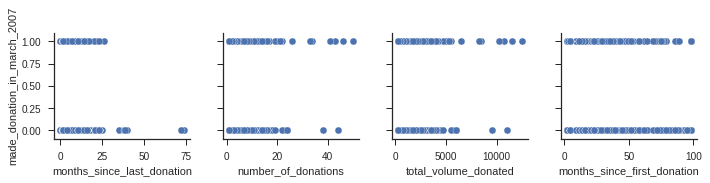

In [6]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

x_columns = df.columns.drop(['made_donation_in_march_2007'])

sns.pairplot(data=df, y_vars=['made_donation_in_march_2007'], x_vars=x_columns)

In [7]:
df.corr()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
months_since_last_donation,1.000000,-0.182745,-0.182745,0.160618,-0.279869
number_of_donations,-0.182745,1.000000,1.000000,0.634940,0.218633
total_volume_donated,-0.182745,1.000000,1.000000,0.634940,0.218633
months_since_first_donation,0.160618,0.634940,0.634940,1.000000,-0.035854
made_donation_in_march_2007,-0.279869,0.218633,0.218633,-0.035854,1.000000


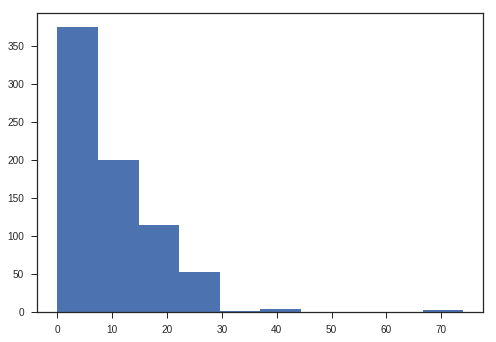

In [8]:
import matplotlib.pyplot as plt
plt.hist(df['months_since_last_donation']);

In [9]:
print(df['months_since_last_donation'].value_counts())

2     173
4     156
11     84
14     76
16     63
23     50
21     44
9      20
3      13
1       9
7       8
5       6
12      6
8       6
0       5
6       5
13      5
10      3
15      2
18      2
38      2
72      1
17      1
20      1
22      1
25      1
26      1
35      1
39      1
40      1
74      1
Name: months_since_last_donation, dtype: int64


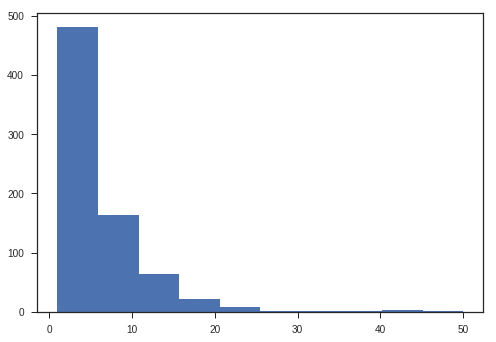

In [10]:
plt.hist(df['number_of_donations']);

In [11]:
print(df['number_of_donations'].value_counts())

1     158
2     112
3      87
4      62
5      62
6      52
7      43
8      31
9      24
11     22
10     14
12     14
16     13
14     13
13      9
15      6
17      4
24      3
19      2
20      2
21      2
22      2
46      1
18      1
23      1
26      1
33      1
34      1
38      1
41      1
43      1
44      1
50      1
Name: number_of_donations, dtype: int64


In [12]:
print(df['made_donation_in_march_2007'].value_counts())

0    570
1    178
Name: made_donation_in_march_2007, dtype: int64


## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [0]:
df.rename(columns={'made_donation_in_march_2007': 'donation'}, inplace=True)

In [0]:
import numpy as np

y = df.donation == 1

majority_class = y.mode()[0]
y_pred = np.full(shape=y.shape, fill_value=majority_class)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.7620320855614974

In [16]:
df.donation.value_counts(normalize=True)

0    0.762032
1    0.237968
Name: donation, dtype: float64

What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

In [0]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

In [18]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.76      1.00      0.86       570
        True       0.00      0.00      0.00       178

   micro avg       0.76      0.76      0.76       748
   macro avg       0.38      0.50      0.43       748
weighted avg       0.58      0.76      0.66       748



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


From a majority class baseline, the recall score is 0 or undefined because you have not applied any model or technique to make any predictions. Without predictions to compute the true positives and false negatives you cannot have a recall score as indicated from the classification report results above.

## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [0]:
X = df[['months_since_last_donation','number_of_donations','total_volume_donated','months_since_first_donation']]

In [21]:
print(X.shape)
print(y.shape)

(748, 4)
(748,)


In [0]:
from sklearn.model_selection import train_test_split

X = df[['months_since_last_donation','number_of_donations','total_volume_donated','months_since_first_donation']]
y = df.donation == 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.25, random_state=42)

## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import f_classif, SelectKBest

pipeline = make_pipeline( 
    RobustScaler(), 
    SelectKBest(f_classif), 
    LogisticRegression())



## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [0]:
from sklearn.model_selection import GridSearchCV

In [29]:
param_grid = {
    'selectkbest__k': [1,2,3,4],
    'LogisticRegression_class_weight': None, balanced,
    'LogisticRegression_C': [0.0001,0.001,0.01,.1,1.0,10.0,100.0,1000.0,10000.0]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=5, 
                  scoring='recall', 
                  verbose=1)

SyntaxError: ignored

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

Calculate accuracy

In [26]:
# Accuracy = (True Positive +  True Negative) / Total
accuracy = (36 + 85) / (85 + 58 + 8 + 36)
print(accuracy)

0.6470588235294118


Calculate precision

In [27]:
# Precision = True Positive / Total Predicted
precision = (36) / (58 + 36)
print(precision)

0.3829787234042553


Calculate recall

In [28]:
# Recall = True Positive / Total Positive
recall = (36)  / (8 + 36)
print(recall)

0.8181818181818182


## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 